In [ ]:
!pip install nbmerge

In [ ]:
# upload all notebooks to this colab directory and run the code ... output_notebook can be downloaded 
# notebooks will be merged in the order as they are listed below!
!nbmerge notebook1.ipynb notebook2.ipynb notebook3.ipynb ... > outbput_notebook_name.ipynb

Traceback (most recent call last):
  File "/usr/local/bin/nbmerge", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/nbmerge/__init__.py", line 189, in main
    plan = parse_plan(args)
  File "/usr/local/lib/python3.7/dist-packages/nbmerge/__init__.py", line 173, in parse_plan
    raise IOError("Notebook `{}` does not exist".format(file_path))
OSError: Notebook `notebook1.ipynb` does not exist


+ inflation rate?
+ Twitter posts?

```
@misc{prajapati2020predictive,
    title={Predictive analysis of Bitcoin price considering social sentiments},
    author={Pratikkumar Prajapati},
    year={2020},
    eprint={2001.10343},
    archivePrefix={arXiv},
    primaryClass={cs.IR}
}
```
https://github.com/pratikpv/predicting_bitcoin_market


# Predictive Bitcoin Price Analysis considerin Social Media Posts
We report on the use of sentiment analysis on news and social media to analyze and predict the price of Bitcoin. Bitcoin is the leading cryptocurrency and has the highest market capitalization among digital currencies. Predicting Bitcoin values may help understand and predict potential market movement and future growth of the technology. Unlike (mostly) repeating phenomena like weather, cryptocurrency values do not follow a repeating pattern and mere past value of Bitcoin does not reveal any secret of future Bitcoin value. Humans follow general sentiments and technical analysis to invest in the market. Hence considering people's sentiment can give a good degree of prediction. We focus on using social sentiment as a feature to predict future Bitcoin value, and in particular, consider Google News and Reddit posts. We find that social sentiment gives a good estimate of how future Bitcoin values may move. We achieve the lowest test RMSE of 434.87 using an LSTM that takes as inputs the historical price of various cryptocurrencies, the sentiment of news articles and the sentiment of Reddit posts.

# Preparation of Data

## Inflaiton rate scraper

In [ ]:
import pandas as pd
import requests 
import json
import plotly.graph_objects as go

'''def scrapeindicator(url):
     
     r = requests.get(url)
     r_json = r.json()
     periods = r_json['series']['docs'][0]['period']
     values = r_json['series']['docs'][0]['value']
     dataset = r_json['series']['docs'][0]['dataset_name']
     indicators = pd.DataFrame(values, index = periods)
     indicators.columns = [dataset]
     return indicators'''

#interest = scrapeindicator('https://api.db.nomics.world/v22/series/Eurostat/ei_mfir_m/M.NSA.NAP.MF-LTGBY-RT.EU28?observations=1')
#inflation = scrapeindicator('https://api.db.nomics.world/v22/series/WB/WDI/FP.CPI.TOTL.ZG-EU?observations=1')

inflation = 'https://api.db.nomics.world/v22/series/WB/WDI/FP.CPI.TOTL.ZG-EU?observations=1'

r = requests.get(inflation)
#print(r)
r_json = r.json()
print(r_json)
#r_json['series']['docs'][0]['period']


{'_meta': {'args': {'align_periods': False, 'dataset_code': 'WDI', 'dimensions': {}, 'facets': False, 'format': 'json', 'limit': 1000, 'metadata': True, 'observations': True, 'offset': 0, 'provider_code': 'WB', 'q': '', 'series_code': 'FP.CPI.TOTL.ZG-EU'}, 'version': '22.1.9'}, 'message': "Series 'WB/WDI/FP.CPI.TOTL.ZG-EU' not found"}


## Reddit Scraper

In [ ]:
import numpy as np
import requests
import json
import csv
import time
import datetime
import os


def get_pushshift_data(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title=' + str(query) + '&size=1000&after=' + str(
        after) + '&before=' + str(before) + '&subreddit=' + str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']


def collect_sub_data(subm):
    sub_data = list()  # list to store data points
    title = subm['title']
    url = subm['url']
    try:
        # if flair is available then get it, else set 'NaN'
        flair = subm['link_flair_text']
    except KeyError:
        flair = 'NaN'
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    try:
        # if selftext is available then get it, else set it empty
        selftext = subm['selftext']
        list_of_empty_markers = ['[removed]', '[deleted]']
        # many times selftext would be removed or deleted, if thats the case then set it empty
        if selftext in list_of_empty_markers:
            selftext = ''
    except:
        selftext = ''
    created = datetime.datetime.fromtimestamp(subm['created_utc'])  # 1520561700.0
    numComms = subm['num_comments']
    permalink = subm['permalink']

    sub_data.append((sub_id, title, selftext, url, author, score, created, numComms, permalink, flair))
    sub_stats[sub_id] = sub_data


def write_subs_to_file(filename):
    upload_count = 0
    if os.path.exists(filename):
        keep_header = False
    else:
        keep_header = True

    with open(filename, 'a', newline='') as file:
        a = csv.writer(file, delimiter=',')
        headers = ['post_id', 'title', 'selftext', 'url', 'author', 'score', 'publish_date', 'num_of_comments',
                   'permalink', 'flair']
        if keep_header:
            a.writerow(headers)
        for sub in sub_stats:
            a.writerow(sub_stats[sub][0])
            upload_count += 1
        # print(str(upload_count) + ' submissions have been uploaded')


if __name__ == '__main__':
    # Download reddit posts from sub_reddit with keywords given by key_word

    sub_reddit = 'bitcoin'
    key_word = 'bitcoin'

    output_filename = 'reddit_data.csv'
    # search all the posts from start_date to end_date overall
    start_date = datetime.datetime(2018, 1, 1, 0)
    end_date = datetime.datetime(2019, 11, 21, 0)

    # in each itration get reddit posts for one day, to avoid getting blocked by server
    one_day = datetime.timedelta(hours=24)
    after_date = start_date
    after = str(int(after_date.timestamp()))
    before_date = start_date + one_day
    before = str(int(before_date.timestamp()))

    while after_date < end_date:
        print('-' * 80)
        print(after_date, ' -> ', before_date)
        print('-' * 80)

        sub_count = 0
        sub_stats = {}

        data = get_pushshift_data(key_word, after, before, sub_reddit)

        max_count = 100
        count = 0
        while len(data) > 0 and count < max_count:
            print('count ', count)
            for submission in data:
                collect_sub_data(submission)
                sub_count += 1

            print(len(data))
            print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
            after = data[-1]['created_utc']
            data = get_pushshift_data(key_word, after, before, sub_reddit)
            # print(data)
            # print(data['data'][0]['author'])
            count = count + 1

        # keep saving data collected in each iteration
        write_subs_to_file(output_filename)

        # move to next day
        after_date += one_day
        after = str(int(after_date.timestamp()))
        before_date += one_day
        before = str(int(before_date.timestamp()))

        # randomly sleep before starting next iteration
        time.sleep(np.random.randint(1, 3))

--------------------------------------------------------------------------------
2018-01-01 00:00:00  ->  2018-01-02 00:00:00
--------------------------------------------------------------------------------
https://api.pushshift.io/reddit/search/submission/?title=bitcoin&size=1000&after=1514764800&before=1514851200&subreddit=bitcoin
count  0
166
2018-01-01 23:59:25
https://api.pushshift.io/reddit/search/submission/?title=bitcoin&size=1000&after=1514851165&before=1514851200&subreddit=bitcoin
--------------------------------------------------------------------------------
2018-01-02 00:00:00  ->  2018-01-03 00:00:00
--------------------------------------------------------------------------------
https://api.pushshift.io/reddit/search/submission/?title=bitcoin&size=1000&after=1514851200&before=1514937600&subreddit=bitcoin
count  0
216
2018-01-02 23:53:41
https://api.pushshift.io/reddit/search/submission/?title=bitcoin&size=1000&after=1514937221&before=1514937600&subreddit=bitcoin
--------

KeyboardInterrupt: ignored

## Reddit Sentiment Analyzer

In [ ]:
#rddt = pd.read_csv('reddit_data.csv')

#rddt.head()

In [ ]:
!pip install flair

In [ ]:
import pandas as pd
import flair
from textblob import TextBlob
import os
import datetime
import numpy as np
import nltk
nltk.download([
    "names",
    "stopwords",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])

from nltk.sentiment import SentimentIntensityAnalyzer

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
fmt = '%Y-%m-%d %H:00:00'
sid = SentimentIntensityAnalyzer()


def get_sentiment_val_for_flair(sentiments):
    """
    parse input of the format [NEGATIVE (0.9284018874168396)] and return +ve or -ve float value
    :param sentiments:
    :return:
    """
    total_sentiment = str(sentiments)
    neg = 'NEGATIVE' in total_sentiment
    if neg:
        total_sentiment = total_sentiment.replace('NEGATIVE', '')
    else:
        total_sentiment = total_sentiment.replace('POSITIVE', '')

    total_sentiment = total_sentiment.replace('(', '').replace('[', '').replace(')', '').replace(']', '')
    #print(total_sentiment)

    val = float(total_sentiment)
    #val = total_sentiment
    if neg:
        return -val
    return val


def get_sentiment_report(input_filename, output_filename):
    df = pd.read_csv(input_filename)
    df = df[['title', 'selftext', 'publish_date']]
    df = df.fillna('')

    df['text'] = df['title'] + ' ' + df['selftext']
    df.set_index('publish_date', inplace=True)
    df.drop(['title', 'selftext'], axis=1, inplace=True)

    for row_i, row in df.iterrows():
        tb_sentiment_polarity_dict = dict()
        tb_sentiment_subjectivity_dict = dict()
        flair_sentiment_dict = dict()

        sid_pos_dict = dict()
        sid_neg_dict = dict()
        sid_neu_dict = dict()
        sid_com_dict = dict()

        data = row['text']
        print(row_i)
        print(data[0:15])
        flair_s = flair.data.Sentence(data)
        flair_sentiment.predict(flair_s)
        flair_total_sentiment = flair_s.labels
        flair_val = get_sentiment_val_for_flair(flair_total_sentiment)

        flair_sentiment_dict[str(row_i)] = flair_val
        tb_sentiment_polarity_dict[str(row_i)] = TextBlob(data).sentiment[0]
        tb_sentiment_subjectivity_dict[str(row_i)] = TextBlob(data).sentiment[1]

        ss = sid.polarity_scores(data)
        sid_pos_dict[str(row_i)] = ss['pos']
        sid_neg_dict[str(row_i)] = ss['neg']
        sid_neu_dict[str(row_i)] = ss['neu']
        sid_com_dict[str(row_i)] = ss['compound']

        flair_df = pd.DataFrame.from_dict(flair_sentiment_dict, orient='index', columns=['reddit_flair'])
        flair_df.index.name = 'timestamp'

        tb_polarity_df = pd.DataFrame.from_dict(tb_sentiment_polarity_dict, orient='index',
                                                columns=['reddit_tb_polarity'])
        tb_polarity_df.index.name = 'timestamp'

        tb_subjectivity_df = pd.DataFrame.from_dict(tb_sentiment_subjectivity_dict, orient='index',
                                                    columns=['reddit_tb_subjectivity'])
        tb_subjectivity_df.index.name = 'timestamp'

        sid_pos_df = pd.DataFrame.from_dict(sid_pos_dict, orient='index',
                                            columns=['reddit_sid_pos'])
        sid_pos_df.index.name = 'timestamp'

        sid_neg_df = pd.DataFrame.from_dict(sid_neg_dict, orient='index',
                                            columns=['reddit_sid_neg'])
        sid_neg_df.index.name = 'timestamp'

        sid_neu_df = pd.DataFrame.from_dict(sid_neu_dict, orient='index',
                                            columns=['reddit_sid_neu'])
        sid_neu_df.index.name = 'timestamp'

        sid_com_df = pd.DataFrame.from_dict(sid_com_dict, orient='index',
                                            columns=['reddit_sid_com'])
        sid_com_df.index.name = 'timestamp'

        final_senti_df = pd.concat([flair_df, tb_polarity_df, tb_subjectivity_df, sid_pos_df, sid_neg_df, sid_neu_df,
        							sid_com_df], axis=1)

        if os.path.exists(output_filename):
            keep_header = False
        else:
            keep_header = True

        final_senti_df.to_csv(output_filename, mode='a', header=keep_header)

    return


def clean_sentiment_report(input_filename, output_filename):
    # drop duplicates and sort
    master_df = pd.read_csv(input_filename, index_col=0)
    master_df.index = pd.to_datetime(master_df.index)
    idx = np.unique(master_df.index, return_index=True)[1]
    master_df = master_df.iloc[idx]
    master_df.to_csv(output_filename)


def bucketize_sentiment_report(input_filename, output_filename):
    start_date_time_obj = datetime.datetime(2018, 1, 1, 0)
    end_date_time_obj = datetime.datetime(2019, 11, 20, 23)
    hr1 = datetime.timedelta(hours=1)
    curr_date_time_obj = start_date_time_obj
    in_df = pd.read_csv(input_filename)


    out_dict = dict()

    while curr_date_time_obj <= end_date_time_obj:
        curr_timestamp = curr_date_time_obj.strftime(format=fmt)
        # print(curr_timestamp)
        # create data dict with all possible timestamps and dummy value of reddit_flair
        # reddit_flair is chosen just randomly as a placeholder
        out_dict[curr_timestamp] = 0
        curr_date_time_obj += hr1

    out_df = pd.DataFrame.from_dict(out_dict, orient='index',
                                    columns=['reddit_flair'])

    # print(out_dict)
    out_df.index.name = 'timestamp'
    # populate more colums
    out_df['reddit_flair_count'] = 0
    out_df['reddit_tb_polarity'] = 0
    out_df['reddit_tb_polarity_count'] = 0
    out_df['reddit_tb_subjectivity'] = 0
    out_df['reddit_tb_subjectivity_count'] = 0
    out_df['reddit_sid_pos'] = 0
    out_df['reddit_sid_neg'] = 0
    out_df['reddit_sid_neu'] = 0
    out_df['reddit_sid_com'] = 0
    out_df['reddit_sid_count'] = 0

    for i in range(len(in_df)):
        timestamp = in_df.loc[i, 'timestamp']
        out_key = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        # timestamp is current plus few minutes or seconds, so collect all these data in the bucket of next hour
        out_key += hr1
        out_key = out_key.strftime(format='%Y-%m-%d %H:00:00')
        #print(out_key)
        # add up all values and count how many values we have added. In next pass we would normalize the values
        try:
            out_df.loc[out_key, 'reddit_flair'] += in_df.loc[i, 'reddit_flair']
            out_df.loc[out_key, 'reddit_flair_count'] += 1
            out_df.loc[out_key, 'reddit_tb_polarity'] += in_df.loc[i, 'reddit_tb_polarity']
            out_df.loc[out_key, 'reddit_tb_polarity_count'] += 1
            out_df.loc[out_key, 'reddit_tb_subjectivity'] += in_df.loc[i, 'reddit_tb_subjectivity']
            out_df.loc[out_key, 'reddit_tb_subjectivity_count'] += 1
            out_df.loc[out_key, 'reddit_sid_pos'] += in_df.loc[i, 'reddit_sid_pos']
            out_df.loc[out_key, 'reddit_sid_neg'] += in_df.loc[i, 'reddit_sid_neg']
            out_df.loc[out_key, 'reddit_sid_neu'] += in_df.loc[i, 'reddit_sid_neu']
            out_df.loc[out_key, 'reddit_sid_com'] += in_df.loc[i, 'reddit_sid_com']
            out_df.loc[out_key, 'reddit_sid_count'] += 1
        except:
            pass

    # make timestamp as a column and reindex the dataframe to make loc method happy
    out_df['timestamp'] = out_df.index
    out_df.index = range(len(out_df))

    for i in range(len(out_df)):
        #print(out_df.loc[i, 'timestamp'])
        # normalize the values
        if out_df.loc[i, 'reddit_flair_count'] == 0:
            out_df.loc[i, 'reddit_flair'] = 0
        else:
            out_df.loc[i, 'reddit_flair'] /= out_df.loc[i, 'reddit_flair_count']

        if out_df.loc[i, 'reddit_tb_polarity_count'] == 0:
            out_df.loc[i, 'reddit_tb_polarity'] = 0
        else:
            out_df.loc[i, 'reddit_tb_polarity'] /= out_df.loc[i, 'reddit_tb_polarity_count']

        if out_df.loc[i, 'reddit_tb_subjectivity_count'] == 0:
            out_df.loc[i, 'reddit_tb_subjectivity'] = 0
        else:
            out_df.loc[i, 'reddit_tb_subjectivity'] /= out_df.loc[i, 'reddit_tb_subjectivity_count']

        if out_df.loc[i, 'reddit_sid_count'] == 0:
            out_df.loc[i, 'reddit_sid_pos'] = 0
            out_df.loc[i, 'reddit_sid_neg'] = 0
            out_df.loc[i, 'reddit_sid_neu'] = 0
            out_df.loc[i, 'reddit_sid_com'] = 0
        else:
            out_df.loc[i, 'reddit_sid_pos'] /= out_df.loc[i, 'reddit_sid_count']
            out_df.loc[i, 'reddit_sid_neg'] /= out_df.loc[i, 'reddit_sid_count']
            out_df.loc[i, 'reddit_sid_neu'] /= out_df.loc[i, 'reddit_sid_count']
            out_df.loc[i, 'reddit_sid_com'] /= out_df.loc[i, 'reddit_sid_count']

        if os.path.exists(output_filename):
            keep_header = False
        else:
            keep_header = True

    out_df.drop(['reddit_flair_count', 'reddit_tb_polarity_count', 'reddit_tb_subjectivity_count','reddit_sid_count'], axis=1,
                inplace=True)
    # change back index to timestamp to save the data in csv
    out_df.set_index('timestamp', inplace=True)
    out_df.to_csv(output_filename)


if __name__ == '__main__':
    input_filename = 'reddit_data.csv'
    output_sentiment_filename = input_filename[0:-4] + '_sentiment.csv'

    # read input_filename (which can be generated by download_data_from_reddit.py script) and performs
    # sentiment analyis of the text data
    get_sentiment_report(input_filename, output_sentiment_filename)
    output_sentiment_bucketize_filename = output_sentiment_filename[0:-4] + '_bucketized.csv'

    # reddit posts can land anytime. Collect all the posts (and its sentiment reports) landed on a given hour (0 to 59 minutes)
    # and bucketize them all into the corresponding hour
    bucketize_sentiment_report(output_sentiment_filename, output_sentiment_bucketize_filename)

## Google News Scraper


In [ ]:
#!pip install newspaper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package newspaper


In [ ]:
import requests
from bs4 import BeautifulSoup
#from newspaper import Article
import datetime
import pandas as pd
import time
import os
import numpy as np

URL = "https://www.google.com/search?q=bitcoin+cryptocurrency&hl=en&gl=us&as_drrb=b&tbas=0&tbs=cdr:1,cd_min:{min_date},cd_max:{max_date},sbd:1&tbm=nws&sxsrf=ACYBGNRfmviSo9arK1e_P_YIl5wsskZBPw:1574225634362&source=lnt&sa=X&ved=0ahUKEwj4wu29__flAhWV9Z4KHaKJAGcQpwUIIA&biw=1685&bih=863&dpr=1.1"

#headers = {
#    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36',
#    'Content-Type': 'text/html',
#}

headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36", 
           "X-Amzn-Trace-Id": "Root=1-633bead1-25865d6f2ec8bb9855899e90"}


max_count = 10  # max 10 news articles per day
fmt = '%m/%d/%Y'
news_cols = ['index', 'date', 'status_code', 'url', 'news_1_url', 'news_1_text',
             'news_1_publish_date', 'news_2_url', 'news_2_text', 'news_2_publish_date',
             'news_3_url', 'news_3_text', 'news_3_publish_date', 'news_4_url',
             'news_4_text', 'news_4_publish_date', 'news_5_url', 'news_5_text',
             'news_5_publish_date', 'news_6_url', 'news_6_text', 'news_6_publish_date',
             'news_7_url', 'news_7_text', 'news_7_publish_date', 'news_8_url',
             'news_8_text', 'news_8_publish_date', 'news_9_url', 'news_9_text',
             'news_9_publish_date']


def run_google_news_scrapper(**params):
    output_file_name = ''
    for key, value in params.items():
        if key == 'min_date':
            min_date = value
        if key == 'output_file':
            output_file_name = value

    news_data_dict = dict()
    columns = []
    news_data_dict['date'] = min_date
    columns.append('date')
    response = requests.get(URL.format(**params), headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    news_data_dict['status_code'] = response.status_code
    columns.append('status_code')
    if response.status_code != 200:
        print("******** fail ********** ")
        return
    # print(response.url)
    news_data_dict['url'] = response.url
    columns.append('url')
    count = 1
    for link in soup.find_all('a'):
        link_str = str(link.get('href'))
        try:
            if link_str.startswith("https://") and link_str.find('google.com') == -1 and link_str.find(
                    "https://www.youtube.com/") == -1 and link_str.find("https://www.blogger.com/") == -1:
                article = Article(link_str)
                article.download()
                article.parse()
                # print(link_str)
                # print(article.authors)
                # print(article.publish_date)
                # print(article.text)
                news_count = 'news_' + str(count)
                news_data_dict[news_count + '_url'] = link_str
                news_data_dict[news_count + '_text'] = article.text
                news_data_dict[news_count + '_publish_date'] = article.publish_date

                columns.append(news_count + '_url')
                columns.append(news_count + '_text')
                columns.append(news_count + '_publish_date')
                count += 1
                if count >= max_count:
                    break

        except:
            pass
    news_data_df = pd.DataFrame(news_data_dict, index=[0],
                                columns=news_cols)

    """
    if os.path.exists(output_file_name):
        keep_header = False
    else:
        keep_header = True

    news_data_df.to_csv(output_file_name, mode='a', header=keep_header)
    """
    news_data_df.to_csv(output_file_name)

    return news_data_dict


def google_news_scrapper(start_date, end_date, output_file_name):
    step_obj = datetime.timedelta(days=1)
    start_date_time_obj = datetime.datetime.strptime(start_date, fmt)
    end_date_time_obj = datetime.datetime.strptime(end_date, fmt)

    while start_date_time_obj <= end_date_time_obj:
        start_date = start_date_time_obj.strftime(fmt)
        print(start_date)
        run_google_news_scrapper(min_date=start_date, max_date=start_date, output_file=output_file_name)
        time.sleep(np.random.randint(2, 5))
        start_date_time_obj += step_obj


def sort_news_report(input_file_name, cleaned_output_file_name, save_index=False):
    df = pd.read_csv(input_file_name)
    df = df.set_index('date', drop=True)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index().drop_duplicates(keep='first')
    df.to_csv(cleaned_output_file_name)
    if save_index:
        df_i = pd.DataFrame(df.index)
        df_i.to_csv(cleaned_output_file_name[0:-4] + '_index.csv')


def clean_news_report(input_file_name, cleaned_output_file_name, save_index=False):
    master_df = pd.read_csv(input_file_name)
    # get only given columns
    master_df = master_df[['date', 'news_1_text', 'news_2_text', 'news_3_text', 'news_4_text', 'news_5_text', 'news_6_text',
             'news_7_text', 'news_8_text', 'news_9_text']]
    master_df = master_df.set_index('date', drop=True)
    master_df.index = pd.to_datetime(master_df.index, format=fmt)
    # soft and drop duplicates
    master_df = master_df.sort_index().drop_duplicates(keep='first')
    idx = np.unique(master_df.index, return_index=True)[1]
    master_df = master_df.iloc[idx]
    master_df.to_csv(cleaned_output_file_name)

    master_df.to_csv(cleaned_output_file_name)
    if save_index:
        df_i = pd.DataFrame(master_df.index)
        df_i.to_csv(cleaned_output_file_name[0:-4] + '_index.csv')


if __name__ == "__main__":
    start_date = '01/01/2018'
    # end_date = datetime.datetime.now().strftime(fmt)
    end_date = '01/02/2019'
    news_raw_filename = 'google_news_final.csv'

    google_news_scrapper(start_date, end_date, news_raw_filename)
    news_cleaned_filename = news_raw_filename[0:-4] + '_cleaned.csv'
    clean_news_report(news_raw_filename, news_cleaned_filename)

01/01/2018
01/02/2018
01/03/2018
01/04/2018
01/05/2018
01/06/2018
01/07/2018
01/08/2018
01/09/2018
01/10/2018
01/11/2018
01/12/2018
01/13/2018
01/14/2018
01/15/2018
01/16/2018
01/17/2018
01/18/2018
01/19/2018
01/20/2018
01/21/2018
01/22/2018
01/23/2018
01/24/2018
01/25/2018
01/26/2018
01/27/2018
01/28/2018
01/29/2018
01/30/2018
01/31/2018
02/01/2018
02/02/2018
02/03/2018
02/04/2018
02/05/2018
02/06/2018
02/07/2018
02/08/2018
02/09/2018
02/10/2018
02/11/2018
02/12/2018
02/13/2018
02/14/2018
02/15/2018
02/16/2018
02/17/2018
02/18/2018
02/19/2018
02/20/2018
02/21/2018
02/22/2018
02/23/2018
02/24/2018
02/25/2018
02/26/2018
02/27/2018
02/28/2018
03/01/2018
03/02/2018
03/03/2018
03/04/2018
03/05/2018
03/06/2018
03/07/2018
03/08/2018
03/09/2018
03/10/2018
03/11/2018
03/12/2018
03/13/2018
03/14/2018
03/15/2018
03/16/2018
03/17/2018
03/18/2018
03/19/2018
03/20/2018
03/21/2018
03/22/2018
03/23/2018
03/24/2018
03/25/2018
03/26/2018
03/27/2018
03/28/2018
03/29/2018
03/30/2018
03/31/2018
04/01/2018

KeyboardInterrupt: ignored

## Google News Sentiment Analyzer

In [ ]:
import pandas as pd
import flair
from textblob import TextBlob
import os
import datetime
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

fmt = '%Y-%m-%d'


def get_sentiment_val_for_flair(sentiments):
    """
    parse input of the format [NEGATIVE (0.9284018874168396)] and return +ve or -ve float value
    :param sentiments:
    :return:
    """
    total_sentiment = str(sentiments)
    neg = 'NEGATIVE' in total_sentiment
    if neg:
        total_sentiment = total_sentiment.replace('NEGATIVE', '')
    else:
        total_sentiment = total_sentiment.replace('POSITIVE', '')

    total_sentiment = total_sentiment.replace('(', '').replace('[', '').replace(')', '').replace(']', '')

    val = float(total_sentiment)
    if neg:
        return -val
    return val


def add_to_dict(final_dict, input_dict):
    """
    add matching key values and store final result in final_dict
    :param final_dict:
    :param input_dict:
    :return:
    """
    for item in final_dict:
        input_dict_val = input_dict.get(item, 0)
        final_dict[item] += input_dict_val


def devide_dict_by_scaler(in_dict, val):
    """
    devide each value of dict by scaler
    :param in_dict:
    :param val:
    :return:
    """
    for item in in_dict:
        in_dict[item] /= val


def get_sentiment_report(input_filename, output_filename, start_date=None, simulate=False):
    """

    :param data_df: input data is panda dataframe, with index as date of the format fmt
    :return: another dataframe with same index as input dataframe and new columns as sentiment values
    """
    data_df = pd.read_csv(input_filename, index_col=0)
    col = data_df.columns

    # sid = SentimentIntensityAnalyzer()
    if simulate:
        flair_sentiment = None
        sid = None
    else:
        flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
        sid = SentimentIntensityAnalyzer()
    temp_c = 0
    for row_i, row in data_df.iterrows():
        temp_c += 1
        # print(row_i)

        if start_date is not None:
            start_date_time_obj = datetime.datetime.strptime(start_date, fmt)
            current_date_time_obj = datetime.datetime.strptime(str(row_i), fmt)

            if current_date_time_obj < start_date_time_obj:
                print('Skipping record of date ', str(current_date_time_obj), ' But looking for ',
                      str(start_date_time_obj))
                continue

        total_sentiment_data_count = 0
        tb_sentiment_polarity_dict = dict()
        tb_sentiment_subjectivity_dict = dict()
        flair_sentiment_dict = dict()

        sid_pos_dict = dict()
        sid_neg_dict = dict()
        sid_neu_dict = dict()
        sid_com_dict = dict()

        flair_sentiment_total = 0

        tb_polarity_total = 0
        tb_subjectivity_total = 0

        sid_pos_total = 0
        sid_neg_total = 0
        sid_neu_total = 0
        sid_com_total = 0

        # sid_polarity_total = {'neg': 0., 'neu': 0., 'pos': 0., 'compound': 0.}

        for col_i in range(len(col)):
            data = (str(row[col_i]))
            # print('\t', col_i)
            if data == 'NaN':
                continue

            if simulate:
                flair_sentiment_total = 5
                tb_polarity_total = 6
                tb_subjectivity_total = 7
                total_sentiment_data_count = 9
            else:
                tb_polarity_total += TextBlob(data).sentiment[0]
                tb_subjectivity_total += TextBlob(data).sentiment[1]

                flair_s = flair.data.Sentence(data)
                flair_sentiment.predict(flair_s)
                flair_total_sentiment = flair_s.labels
                flair_val = get_sentiment_val_for_flair(flair_total_sentiment)
                flair_sentiment_total += flair_val

                ss = sid.polarity_scores(data)
                sid_pos_total += ss['pos']
                sid_neg_total += ss['neg']
                sid_neu_total += ss['neu']
                sid_com_total += ss['compound']

                total_sentiment_data_count += 1

        print(str(row_i), ' ', temp_c)
        flair_sentiment_dict[str(row_i)] = flair_sentiment_total / total_sentiment_data_count
        tb_sentiment_polarity_dict[str(row_i)] = tb_polarity_total / total_sentiment_data_count
        tb_sentiment_subjectivity_dict[str(row_i)] = tb_subjectivity_total / total_sentiment_data_count
        print(flair_sentiment_dict[str(row_i)], tb_sentiment_polarity_dict[str(row_i)],
              tb_sentiment_subjectivity_dict[str(row_i)])

        flair_df = pd.DataFrame.from_dict(flair_sentiment_dict, orient='index', columns=['gnews_flair'])
        flair_df.index.name = 'date'

        tb_polarity_df = pd.DataFrame.from_dict(tb_sentiment_polarity_dict, orient='index',
                                                columns=['gnews_tb_polarity'])
        tb_polarity_df.index.name = 'date'

        tb_subjectivity_df = pd.DataFrame.from_dict(tb_sentiment_subjectivity_dict, orient='index',
                                                    columns=['gnews_tb_subjectivity'])
        tb_subjectivity_df.index.name = 'date'

        sid_pos_dict[str(row_i)] = sid_pos_total / total_sentiment_data_count
        sid_neg_dict[str(row_i)] = sid_neg_total / total_sentiment_data_count
        sid_neu_dict[str(row_i)] = sid_neu_total / total_sentiment_data_count
        sid_com_dict[str(row_i)] = sid_com_total / total_sentiment_data_count

        sid_pos_df = pd.DataFrame.from_dict(sid_pos_dict, orient='index',
                                            columns=['gnews_sid_pos'])
        sid_pos_df.index.name = 'timestamp'

        sid_neg_df = pd.DataFrame.from_dict(sid_neg_dict, orient='index',
                                            columns=['gnews_sid_neg'])
        sid_neg_df.index.name = 'timestamp'

        sid_neu_df = pd.DataFrame.from_dict(sid_neu_dict, orient='index',
                                            columns=['gnews_sid_neu'])
        sid_neu_df.index.name = 'timestamp'

        sid_com_df = pd.DataFrame.from_dict(sid_com_dict, orient='index',
                                            columns=['gnews_sid_com'])
        sid_com_df.index.name = 'timestamp'

        final_senti_df = pd.concat([flair_df, tb_polarity_df, tb_subjectivity_df, sid_pos_df, sid_neg_df,
                            sid_neu_df, sid_com_df], axis=1)

        if os.path.exists(output_filename):
            keep_header = False
        else:
            keep_header = True

        final_senti_df.to_csv(output_filename, mode='a', header=keep_header)

    return


def clean_sentiment_report(input_filename, output_filename):
    # drop duplicates and sort
    master_df = pd.read_csv(input_filename, index_col=0)
    master_df.index = pd.to_datetime(master_df.index)
    idx = np.unique(master_df.index, return_index=True)[1]
    master_df = master_df.iloc[idx]
    master_df.to_csv(output_filename)


if __name__ == "__main__":
    input_filename = 'google_news_final.csv'
    output_filename = input_filename[0:-4] + '_sentiment.csv'
    get_sentiment_report(input_filename, output_filename, simulate=False)
    clean_sentiment_report(output_filename, output_filename)

2022-10-28 16:10:03,726 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


ValueError: ignored

## Cryptocurrency Scraper

In [ ]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
import time
from binance.client import Client
from datetime import timedelta, datetime
import pytz
import numpy as np

epoch = 0
fmt = "%Y-%m-%d %H:%M:%S"  # e.g. 2019-11-16 23:16:15
org_columns = ['open',
               'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
               'trades', 'tb_base_av', 'tb_quote_av', 'ignore']

columns_of_interest = ['open', 'high', 'low', 'close', 'volume']


def init_mod():
    # refer: https://www.binance.com/en/support/articles/360002502072 for API keys
    binance_api_key = "your api key here"
    binance_api_secret = "your api secret here"
    binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)
    global epoch
    epoch = datetime.utcfromtimestamp(0)
    return binance_client


def convert_time_to_utc(pst_time):
    utc = pytz.utc
    pst = pytz.timezone('America/Los_Angeles')
    datetime1 = datetime.strptime(pst_time, fmt)
    pst_time = pst.localize(datetime1)
    return pst_time.astimezone(utc).strftime(fmt)


def convert_time_to_pst(utc_time):
    datetime_obj = datetime.strptime(utc_time, fmt)
    return datetime_obj.replace(tzinfo=time.timezone('UTC')).strftime(fmt)


def to_unixmillis(from_date):
    from_date_obj = datetime.strptime(from_date, fmt)
    past = datetime(1970, 1, 1, tzinfo=from_date_obj.tzinfo)
    return int((from_date_obj - past).total_seconds() * 1000.0)


def to_datetime(ms):
    return datetime.fromtimestamp(int(float(ms) / 1000.0))


def download_data_from_binance(symbol, from_date, to_date, output_filename, step=0, pause=-1, simulate=False):
    """

    :param symbol:
    :param from_date:
    :param to_date:
    :param output_filename:
    :param step: step in number of days. Download data in batches of days given by 'step'
    :param pause: pause seconds before downloading next batch.
        if pause == -1 --> random sleep(2,5)
        if pause == 0 --> no sleep
        if pause == num--> sleep for num of seconds
    :param simulate:
    :return:
    """
    binance_client = init_mod()
    from_date_obj = datetime.strptime(from_date, fmt)
    step_date_obj = from_date_obj + timedelta(days=step)
    step_date = step_date_obj.strftime(fmt)

    from_millis = to_unixmillis(from_date)
    to_millis = to_unixmillis(to_date)
    step_millis = to_unixmillis(step_date)

    count = 0
    while True:
        from_millis_str = str(from_millis)
        step_millis_str = str(step_millis)
        print('Step %d:Downloading data from %s to %s' % (count,
                                                          str(to_datetime(from_millis_str)),
                                                          str(to_datetime(step_millis_str))
                                                          ))
        if not simulate:
            # download data

            klines = binance_client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR,
                                                          from_millis_str, end_str=step_millis_str)
            klines_len = len(klines)
            if klines_len == 0:
                print('\t Failed to download from %s to %s. Got %d' % (str(to_datetime(from_millis_str)),
                                                                       str(to_datetime(step_millis_str)), klines_len
                                                                       ))
                time.sleep(5)

            print('\t Downloaded data of len %d from %s to %s' % (klines_len,
                                                                  str(to_datetime(from_millis_str)),
                                                                  str(to_datetime(step_millis_str))
                                                                  ))
            new_columns = [item + '_' + symbol for item in org_columns]
            new_columns.insert(0, 'timestamp')

            data_df = pd.DataFrame(klines,
                                   columns=new_columns)
            data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='ms')
            data_df.set_index('timestamp', inplace=True)
            data_df.to_csv(output_filename)

        # move to next step of batches
        from_millis = step_millis
        step_date_obj = step_date_obj + timedelta(days=step)
        step_date = step_date_obj.strftime(fmt)
        step_millis = to_unixmillis(step_date)
        count = count + 1
        if pause == -1:
            pause = np.random.randint(2, 5)
        time.sleep(pause)
        if step_millis >= to_millis:
            break


def concat_binance_data(symbol_list, output_filename):
    df_list = []
    for num, symbol in enumerate(symbol_list):
        filename = str('%s-binance-data.csv' % (symbol))
        df = pd.read_csv(filename, index_col=0)
        df_list.append(df)

    result = pd.concat(df_list, axis=1, sort=True)
    result.index = pd.to_datetime(df.index)
    result = result.sort_index().drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]

    new_columns = [item + '_' + 'BTCUSDT' for item in columns_of_interest]
    # new_columns.insert(0, 'timestamp')

    for num, symbol in enumerate(symbol_list):
        if symbol == 'BTCUSDT':
            continue
        new_columns.append('close_' + symbol)
        new_columns.append('volume_' + symbol)

    result = result[new_columns]
    result.to_csv(output_filename)


def remove_dup_by_index(output_filename):
    result = pd.read_csv(output_filename, index_col=0)
    result.index = pd.to_datetime(result.index)
    result = result.sort_index()        #.drop_duplicates(keep='first')
    idx = np.unique(result.index, return_index=True)[1]
    result = result.iloc[idx]
    result.to_csv(output_filename)


def append_binance_data(master_output_filename, concat_output_filename):
    master_df = pd.read_csv(master_output_filename)
    new_df = pd.read_csv(concat_output_filename)
    master_df = master_df.append(new_df)
    master_df.set_index('timestamp', inplace=True)
    master_df.index = pd.to_datetime(master_df.index)
    master_df = master_df.sort_index().drop_duplicates(keep='first')
    master_df.to_csv(master_output_filename)


if __name__ == '__main__':
    from_date = '2019-11-16 00:00:00'
    # to_date = time.strftime(fmt, time.localtime())
    # UTC time is 8 hrs ahead of PST
    to_date = '2019-11-19 00:00:00'
    symbol_list = ['LTCUSD', 'ETHUSD', 'BTCUSDT']

    for num, symbol in enumerate(symbol_list):
        output_filename = '%s-binance-data.csv' % (symbol)
        print('-' * 60)
        print('Downloading data from %s to %s for %s' % (from_date, to_date, symbol))
        print('-' * 60)
        download_data_from_binance(symbol, from_date, to_date, output_filename, step=1, pause=-1, simulate=False)

    # concat all currency data
    concat_output_filename = 'binance_crypto_data_final_cleaned.csv'
    concat_binance_data(symbol_list, concat_output_filename)

    # Append the results to master currency data
    master_output_filename = 'crypto_data_master_cleaned.csv'
    append_binance_data(master_output_filename, concat_output_filename)
    remove_dup_by_index(master_output_filename)

------------------------------------------------------------
------------------------------------------------------------
Step 0:Downloading data from 2019-11-16 00:00:00 to 2019-11-17 00:00:00


BinanceAPIException: ignored

## File Merger (compiling social media sentiments and crypto data)

In [ ]:
import pandas as pd
from datetime import datetime, timedelta


def list_diff(list1, list2):
    """"
    returns list1 - list2 and list2 - list1
    to find difference between 2 lists.
    """
    l1_l2 = []
    l2_l1 = []
    for ele in list1:
        if not ele in list2:
            l1_l2.append(ele)

    for ele in list2:
        if not ele in list1:
            l2_l1.append(ele)

    return l1_l2, l2_l1


def merge_crypto_gnews_sentiment(crypto_data_filename, google_news_data_filename, output_data_filename):
    """

    News data is per day, and crypto data is per hour.
    So news data is replicated 24 times for each hour w.r.t. each day so that it can be concatinated with crypto data

    :param crypto_data_filename:
    :param google_news_data_filename:
    :param output_data_filename:
    :return:
    """
    crypto_df = pd.read_csv(crypto_data_filename, index_col=0)
    crypto_df.index = pd.to_datetime(crypto_df.index)
    news_df = pd.read_csv(google_news_data_filename, index_col=0)

    ilist = [str(d) for d in news_df.index]
    hr1 = timedelta(hours=1)
    news_col = list(news_df.columns)
    news_df_comb = pd.DataFrame(columns=news_col)

    for ilist_index, ilist_item in enumerate(ilist):
        dt = datetime.strptime(ilist_item, '%Y-%m-%d')
        for hr_ in range(0, 24):
            row_id_new = dt.strftime('%Y-%m-%d %H:00:00')
            row_id_value = news_df.loc[ilist_item]
            dt += hr1
            news_df_comb.loc[row_id_new] = row_id_value
    news_df_comb.index.name = 'timestamp'
    news_df_comb.to_csv(google_news_data_filename[0:-4] + '_with_timestamp.csv')
    result = pd.concat([crypto_df, news_df_comb], axis=1)
    result.to_csv(output_data_filename)

    return True


def merge_crypto_gnews_reddit_sentiment(crypto_gnews_filename, reddit_data_filename, crypto_gnews_reddit_filename):
    crypto_gnews_df = pd.read_csv(crypto_gnews_filename, index_col=0)
    reddit_df = pd.read_csv(reddit_data_filename, index_col=0)
    result = pd.concat([crypto_gnews_df, reddit_df], axis=1)
    result.to_csv(crypto_gnews_reddit_filename)


if __name__ == '__main__':
    crypto_data_filename = 'crypto_data_master_cleaned.csv'
    gnews_data_filename = 'google_news_final_sentiment.csv'
    crypto_gnews_filename = 'crypto_data_news_final.csv'
    reddit_data_filename = 'reddit_data_sentiment_bucketized.csv'
    crypto_gnews_reddit_filename = 'crypto_data_news_reddit_final.csv'
    merge_crypto_gnews_sentiment(crypto_data_filename, gnews_data_filename, crypto_gnews_filename)
    merge_crypto_gnews_reddit_sentiment(crypto_gnews_filename, reddit_data_filename, crypto_gnews_reddit_filename)

#### Alternative: Downloading csv file from GitHub


In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/pratikpv/predicting_bitcoin_market/master/crypto_data_news_reddit_final.csv'
df = pd.read_csv(url, index_col=0, parse_dates=[0]) # timestamp as index

# exporting df to a csv file
df.to_csv('crypto_data_news_reddit_final.csv')

In [ ]:
df.head()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23,728.77,625.293831,0.04257,...,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36,724.27,710.891607,0.04257,...,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55,722.11,849.257651,0.04257,...,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81,733.19,556.397003,0.04257,...,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39,738.59,1247.722800,0.04257,...,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757


# ML Models

## Model evaluation with PyCaret

### Setup & Required Packages
[Original Colab Notebook](https://colab.research.google.com/drive/1iVo19vQtD5hk-Kcjuqb2Vg33bMnA1vLu?usp=sharing#scrollTo=21GdgQ6cR2aa&line=1&uniqifier=1)

In [ ]:
# run this cell to install pycaret in Google Colab
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 14.6 MB/s 
     |████████████████████████████████| 16.5 MB 68.1 MB/s 
     |████████████████████████████████| 1.7 MB 51.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.0 MB 50.1 MB/s 
     |████████████████████████████████| 88 kB 9.3 MB/s 
     |████████████████████████████████| 25.8 MB 1.2 MB/s 
     |████████████████████████████████| 141 kB 78.0 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 35.8 MB/s 
     |████████████████████████████████| 3.3 MB 56.0 MB/s 
     |████████████████████████████████| 6.8 MB 64.9 MB/s 
     |████████████████████████████████| 325 kB 78.1 MB/s 
     |████████████████████████████████|

In [ ]:
from pycaret.utils import version
version()

'2.3.10'

In [ ]:
# version required by pycaret
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 15.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.8 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [ ]:
from pycaret.regression import *
import pandas as pd
import matplotlib.pyplot as plt

### Preparing the data set

In [ ]:
url = 'https://raw.githubusercontent.com/pratikpv/predicting_bitcoin_market/master/crypto_data_news_reddit_final.csv'
df = pd.read_csv(url, index_col=0, parse_dates=[0])
df.head()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23,728.77,625.293831,0.04257,...,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36,724.27,710.891607,0.04257,...,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55,722.11,849.257651,0.04257,...,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81,733.19,556.397003,0.04257,...,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39,738.59,1247.722800,0.04257,...,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757


In [ ]:
nm = 1
for _ in df.columns:
  print(f'column{nm:3}: {_}')
  nm += 1

column  1: open_BTCUSDT
column  2: high_BTCUSDT
column  3: low_BTCUSDT
column  4: close_BTCUSDT
column  5: volume_BTCUSDT
column  6: close_LTCUSD
column  7: volume_LTCUSD
column  8: close_ETHUSD
column  9: volume_ETHUSD
column 10: gnews_flair
column 11: gnews_tb_polarity
column 12: gnews_tb_subjectivity
column 13: gnews_sid_pos
column 14: gnews_sid_neg
column 15: gnews_sid_neu
column 16: gnews_sid_com
column 17: reddit_flair
column 18: reddit_tb_polarity
column 19: reddit_tb_subjectivity
column 20: reddit_sid_pos
column 21: reddit_sid_neg
column 22: reddit_sid_neu
column 23: reddit_sid_com


In [ ]:
df.shape

(16536, 23)

**Do not confuse with training-testing data!**

*we use 10% of the data to test our model afterwardsf - in other words- we simulate a real life situation, where we feed the model with data it has never seen*

In [ ]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)
data_unseen.to_csv('unseen_data.csv')

print(f'Data for Modeling: %s' %str(data.shape))
print(f'Unseen Data For Predictions: %s' %str(data_unseen.shape))

Data for Modeling: (14882, 23)
Unseen Data For Predictions: (1654, 23)


Training & Test data are all row but the last 100 rows

The last 100 rows are used for prediciton

In [ ]:
data = df.drop(df.tail(100).index)
data_unseen = df.tail(100)
data_unseen.to_csv('last100unseen.csv')

print(f'Data for Modeling: %s' %str(data.shape))
print(f'Unseen Data For Predictions: %s' %str(data_unseen.shape))

Data for Modeling: (16436, 24)
Unseen Data For Predictions: (100, 24)


In [ ]:
data_unseen.head()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,gnews_tb_polarity,gnews_tb_subjectivity,gnews_sid_pos,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:00:00,13483.06,13483.07,13256.90,13416.60,144.830329,223.92,673.85,737.99,1065.503293,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,-0.140941,0.013265,0.177806,0.064600,0.015600,0.919800,-0.051820
2018-01-01 20:00:00,13244.15,13481.00,13244.15,13403.05,232.027888,224.20,500.52,754.27,2086.791608,0.042570,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.107602,0.021970,0.096380,0.161222,0.000000,0.838778,0.244689
2018-01-02 13:00:00,13535.19,13813.00,13535.18,13770.00,393.394609,258.97,2627.80,855.63,3925.713555,0.548481,0.067509,0.306516,0.109111,0.039667,0.851000,0.625567,0.076333,0.093659,0.288849,0.067278,0.038444,0.894222,0.181872
2018-01-02 15:00:00,13819.29,13820.48,13600.40,13701.30,296.147232,250.00,1031.42,863.80,3611.034668,0.548481,0.067509,0.306516,0.109111,0.039667,0.851000,0.625567,-0.610255,0.090833,0.272500,0.114500,0.049000,0.836500,0.160700
2018-01-03 09:00:00,15132.04,15152.66,14807.10,14859.09,441.413661,245.00,809.66,859.47,1324.808471,-0.076384,0.091747,0.323169,0.113667,0.029333,0.857111,0.621256,0.290499,0.124708,0.338616,0.144647,0.031294,0.824118,0.249765


In [ ]:
seen_id = data.index
unseen_id = data_unseen.index

print(len(seen_id), len(unseen_id))

14882 1654


In [ ]:
data.columns

Index(['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT',
       'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'gnews_flair', 'gnews_tb_polarity',
       'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg',
       'gnews_sid_neu', 'gnews_sid_com', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

### Summary and Comparison of different Models:
+ Mean Absolute Error
+ Mean Square Error
+ Root Mean Squared Error
+ R-squared
+ Root Mean Squared Logaritmic Error
+ Mean Absolute Percentage Error
+ Mean Percentage Error

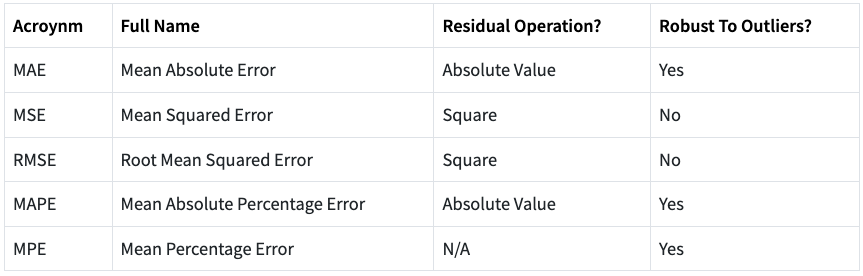

[SOURCE](https://www.dataquest.io/blog/understanding-regression-error-metrics/)


In [ ]:
# ~ 4.5 min runtime
target_col = str(input())
# session_id for reproducability
setup(data, target = target_col, train_size = 0.80, session_id = 1)
setup_df = pull()
# ranking based on R-squared
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,31.5802,3.141255e+03,55.9356,0.9995,0.0067,0.0041,0.266
rf,Random Forest Regressor,31.1725,3.451057e+03,58.6127,0.9995,0.0068,0.0039,9.871
ridge,Ridge Regression,31.5604,3.141174e+03,55.9344,0.9995,0.0067,0.0041,0.013
br,Bayesian Ridge,31.5453,3.144147e+03,55.9594,0.9995,0.0067,0.0041,0.019
lar,Least Angle Regression,31.9160,3.170103e+03,56.2125,0.9995,0.0068,0.0041,0.016
omp,Orthogonal Matching Pursuit,31.9973,3.154895e+03,56.0693,0.9995,0.0068,0.0042,0.014
en,Elastic Net,31.5483,3.144499e+03,55.9626,0.9995,0.0067,0.0041,0.062
huber,Huber Regressor,29.5470,3.537109e+03,59.2735,0.9995,0.0068,0.0037,0.184
lasso,Lasso Regression,31.5493,3.144493e+03,55.9625,0.9995,0.0067,0.0041,0.014
et,Extra Trees Regressor,31.2170,3.508769e+03,59.1161,0.9995,0.0068,0.0039,3.762


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:compare_models() succesfully completed......................................


### Creating an Extra Trees Regressor Model

In [ ]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,30.1017,3165.5235,56.2630,0.9995,0.0063,0.0038
1,33.0400,3611.2896,60.0940,0.9995,0.0068,0.0041
2,31.0728,3289.4295,57.3535,0.9995,0.0063,0.0038
3,31.3639,3888.3272,62.3565,0.9994,0.0071,0.0039
4,30.3319,3013.7271,54.8974,0.9996,0.0063,0.0037
5,30.4031,3113.9211,55.8025,0.9996,0.0074,0.0039
6,31.3074,4224.7563,64.9981,0.9994,0.0079,0.0039
7,30.5736,3188.7318,56.4689,0.9995,0.0068,0.0038
8,33.2983,4320.7359,65.7323,0.9994,0.0070,0.0039


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


#### Optional: manipulation of hyperparameters with tuning

In [ ]:
#tuned_et = tune_model(et, fold=10)

In [ ]:
#tune_model(et, optimize = 'R2')

### Visualization of the Model

#### Residual Plot

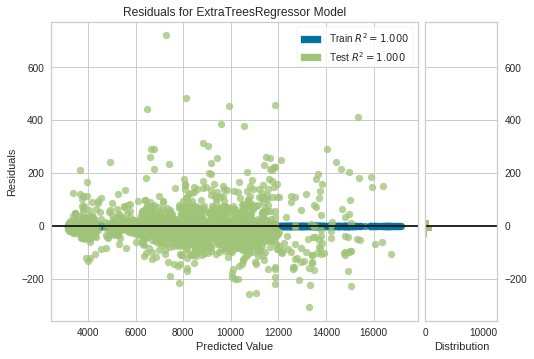

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(et)

#### Prediction Error Plot

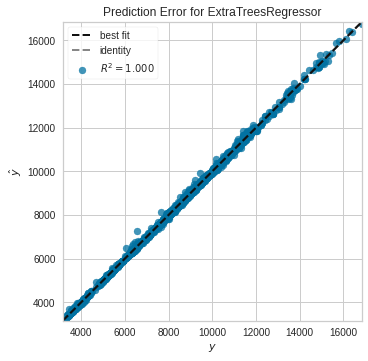

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(et, plot = 'error')

#### Feature Importance Plot

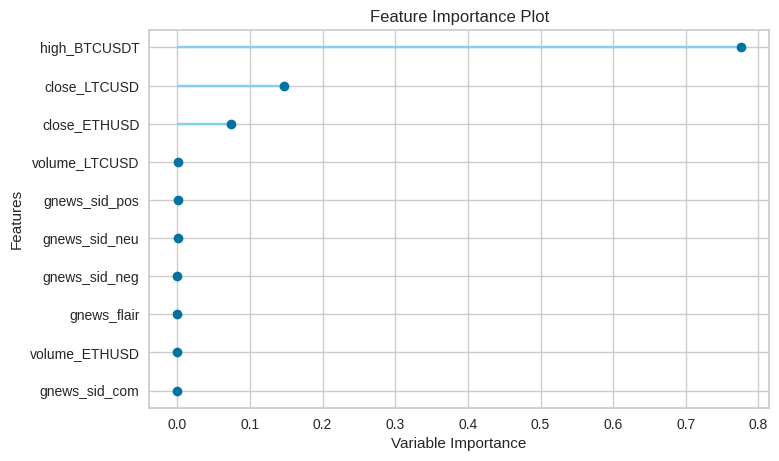

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(et, plot='feature')

In [ ]:
# all possible plots
evaluate_model(et)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Finalizing the model

In [ ]:
final_et = finalize_model(et)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples

### Saving the Model


In [ ]:
save_model(final_et, 'bitcoin_et_2')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False), model_name=bitcoin_et_2, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='open_BTCUSDT',
                               

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='open_BTCUSDT',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_str...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=Non

### Data Engineering - performance of trained model 

In [ ]:
seen_predictions = predict_model(et)
labels = seen_predictions.pop('Label')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
seen_predictions.insert(1, 'Predicted Price', labels)
# preview
seen_predictions.head(n=10)
#seen_predictions.set_index(seen_id)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,30.7452,3092.3413,55.6088,0.9995,0.0068,0.0039


,high_BTCUSDT,Predicted Price,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,gnews_tb_polarity,gnews_tb_subjectivity,...,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,open_BTCUSDT
0,7000.000000,6974.359185,9.306131,75.300003,0.000000,405.040009,309.247620,0.140587,0.049385,0.291547,...,0.913000,0.535500,-0.767098,0.000000,0.500000,0.215000,0.000000,0.785000,0.389150,6941.779785
1,6582.810059,6577.149126,0.760517,58.820000,0.000000,226.419998,1.090000,-0.730817,0.054875,0.404864,...,0.867556,0.387444,-0.635950,0.000000,0.000000,0.298000,0.000000,0.702000,0.177900,6581.370117
2,6956.979980,6914.988306,91.751953,116.760002,627.669983,393.839996,550.712830,-0.164338,0.076910,0.316789,...,0.853111,0.501089,0.473442,0.071374,0.288609,0.072250,0.032250,0.895500,0.127450,6956.979980
3,5170.529785,5160.377412,5.246355,71.330002,9.210000,154.039993,168.927597,0.551718,0.077388,0.333782,...,0.898556,0.497489,-0.999945,0.193182,0.477273,0.000000,0.000000,1.000000,0.000000,5154.720215
4,7624.310059,7588.504497,21.330667,122.000000,18.430000,609.000000,275.062012,0.356533,0.093753,0.396333,...,0.886222,0.144811,0.005770,0.134722,0.101852,0.221333,0.087333,0.691500,0.222633,7596.069824
5,3811.639893,3808.196055,0.429609,48.160000,103.300003,133.389999,35.977890,-0.335663,0.036321,0.214614,...,0.939222,0.369922,-0.982917,-0.093924,0.577257,0.086000,0.010000,0.904000,0.645900,3811.639893
6,6495.589844,6484.425903,20.587435,75.300003,0.000000,218.009995,364.908203,0.330325,0.116206,0.337279,...,0.895667,0.580344,0.296894,0.033333,0.244444,0.066667,0.000000,0.933333,0.042667,6455.439941
7,6327.509766,6299.815571,83.740967,75.300003,0.000000,276.670013,315.225891,-0.126714,0.125561,0.407761,...,0.853000,0.917033,-0.297438,0.066646,0.332909,0.083222,0.064889,0.851889,0.227533,6299.990234
8,6370.040039,6359.122061,61.441212,80.559998,175.869995,450.459991,152.818069,-0.328804,0.111070,0.416766,...,0.870444,0.758378,0.196729,0.250000,0.750000,0.112500,0.000000,0.887500,0.220200,6370.029785
9,10060.200195,9891.885576,944.201294,161.500000,2056.290039,1028.189941,5677.450195,0.131832,0.063560,0.380287,...,0.874778,0.416678,0.195810,-0.040625,0.059375,0.059000,0.027125,0.913875,0.134137,10007.419922


### Data Engineering - predicting unseen data
 

In [ ]:
# this is the remaining 10% of the data which we did not use to train the model
#unseen_predictions = predict_model(final_et, data=data_unseen)

# this previously saved version consists of 50% of the entire data set -> upload dataset!!!
unseen_data = pd.read_csv('unseen_data.csv', index_col = 0, parse_dates=[0])
#unseen_data = pd.read_csv('last100unseen.csv', index_col = 0, parse_dates=[0])
unseen_predictions = predict_model(final_et, data=unseen_data)


# popping the Label column with the predicted values 
labels = unseen_predictions.pop('Label')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
unseen_predictions.insert(1, 'Predicted Price', labels)
# preview
unseen_predictions.head(n=10)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,30.0505,2978.804,54.5784,0.9995,0.0064,0.0037


,open_BTCUSDT,Predicted Price,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:00:00,13483.06,13378.383701,13483.07,13256.90,13416.60,144.830329,223.92,673.85,737.99,1065.503293,...,0.025222,0.909556,0.624667,-0.140941,0.013265,0.177806,0.064600,0.015600,0.919800,-0.051820
2018-01-01 20:00:00,13244.15,13408.815947,13481.00,13244.15,13403.05,232.027888,224.20,500.52,754.27,2086.791608,...,0.025222,0.909556,0.624667,0.107602,0.021970,0.096380,0.161222,0.000000,0.838778,0.244689
2018-01-02 13:00:00,13535.19,13692.047930,13813.00,13535.18,13770.00,393.394609,258.97,2627.80,855.63,3925.713555,...,0.039667,0.851000,0.625567,0.076333,0.093659,0.288849,0.067278,0.038444,0.894222,0.181872
2018-01-02 15:00:00,13819.29,13671.803047,13820.48,13600.40,13701.30,296.147232,250.00,1031.42,863.80,3611.034668,...,0.039667,0.851000,0.625567,-0.610255,0.090833,0.272500,0.114500,0.049000,0.836500,0.160700
2018-01-03 09:00:00,15132.04,14979.483320,15152.66,14807.10,14859.09,441.413661,245.00,809.66,859.47,1324.808471,...,0.029333,0.857111,0.621256,0.290499,0.124708,0.338616,0.144647,0.031294,0.824118,0.249765
2018-01-03 16:00:00,15113.64,15062.177168,15252.70,15080.53,15113.16,462.762658,247.90,856.64,874.23,3858.524028,...,0.029333,0.857111,0.621256,0.383915,0.173550,0.414690,0.121950,0.040000,0.838000,0.122780
2018-01-04 00:00:00,15144.00,15007.528437,15198.00,15035.11,15109.52,407.857564,240.10,1007.59,937.60,4870.806735,...,0.047667,0.856000,0.289800,0.047093,0.206917,0.465815,0.168750,0.027125,0.804125,0.304500
2018-01-04 10:00:00,14475.88,14482.175703,14672.76,14199.98,14373.06,892.695007,230.00,680.04,924.97,3577.827218,...,0.047667,0.856000,0.289800,0.226028,0.178819,0.424606,0.123333,0.100267,0.776400,0.084773
2018-01-04 20:00:00,14986.90,14888.425889,15093.00,14852.90,14879.00,465.379486,230.70,2945.51,950.61,9584.881884,...,0.047667,0.856000,0.289800,-0.209137,0.214348,0.351430,0.133375,0.027125,0.839500,0.181212


### Preparing seen and unseen dataframes for Visualization

In [ ]:
url = 'https://raw.githubusercontent.com/pratikpv/predicting_bitcoin_market/master/crypto_data_news_reddit_final.csv'
df = pd.read_csv(url, index_col=0, parse_dates=[0])

full_dt = df.index
incomp_dt = unseen_predictions.index

### Visualization with Matplotlib

In [ ]:
d = pd.DataFrame(columns=['A'], index=range(len(full_dt)))

In [ ]:
d['timestamp'] = full_dt
d = d.set_index(full_dt)
llll = d.pop('timestamp')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
d.insert(0, 'timestamP', llll)
d

,timestamP,A
timestamp,,
2018-01-01 00:00:00,2018-01-01 00:00:00,NaN
2018-01-01 01:00:00,2018-01-01 01:00:00,NaN
2018-01-01 02:00:00,2018-01-01 02:00:00,NaN
2018-01-01 03:00:00,2018-01-01 03:00:00,NaN
2018-01-01 04:00:00,2018-01-01 04:00:00,NaN
...,...,...
2019-11-20 19:00:00,2019-11-20 19:00:00,NaN
2019-11-20 20:00:00,2019-11-20 20:00:00,NaN
2019-11-20 21:00:00,2019-11-20 21:00:00,NaN


In [ ]:
unseen_predictions.insert(0, 'timestamP', incomp_dt)
unseen_predictions

,timestamP,open_BTCUSDT,Predicted Price,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:00:00,2018-01-01 05:00:00,13483.06,13378.383701,13483.07,13256.90,13416.60,144.830329,223.92,673.85000,737.99,...,0.025222,0.909556,0.624667,-0.140941,0.013265,0.177806,0.064600,0.015600,0.919800,-0.051820
2018-01-01 20:00:00,2018-01-01 20:00:00,13244.15,13408.815947,13481.00,13244.15,13403.05,232.027888,224.20,500.52000,754.27,...,0.025222,0.909556,0.624667,0.107602,0.021970,0.096380,0.161222,0.000000,0.838778,0.244689
2018-01-02 13:00:00,2018-01-02 13:00:00,13535.19,13692.047930,13813.00,13535.18,13770.00,393.394609,258.97,2627.80000,855.63,...,0.039667,0.851000,0.625567,0.076333,0.093659,0.288849,0.067278,0.038444,0.894222,0.181872
2018-01-02 15:00:00,2018-01-02 15:00:00,13819.29,13671.803047,13820.48,13600.40,13701.30,296.147232,250.00,1031.42000,863.80,...,0.039667,0.851000,0.625567,-0.610255,0.090833,0.272500,0.114500,0.049000,0.836500,0.160700
2018-01-03 09:00:00,2018-01-03 09:00:00,15132.04,14979.483320,15152.66,14807.10,14859.09,441.413661,245.00,809.66000,859.47,...,0.029333,0.857111,0.621256,0.290499,0.124708,0.338616,0.144647,0.031294,0.824118,0.249765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 06:00:00,2019-11-20 06:00:00,8124.19,8132.059399,8138.75,8109.41,8118.95,0.966119,55.62,44.38322,176.43,...,0.045111,0.864333,0.457411,0.455501,0.044819,0.136350,0.057375,0.038000,0.904625,0.127800
2019-11-20 07:00:00,2019-11-20 07:00:00,8130.39,8129.107104,8138.20,8118.23,8122.44,1.067848,55.50,2.60382,176.45,...,0.045111,0.864333,0.457411,-0.062698,0.191905,0.280000,0.171286,0.004143,0.824571,0.404186
2019-11-20 08:00:00,2019-11-20 08:00:00,8122.44,8111.727383,8130.93,8083.11,8094.32,2.361535,55.10,23.07439,176.01,...,0.045111,0.864333,0.457411,0.976470,0.127083,0.137500,0.064000,0.029333,0.906667,0.151733


In [ ]:
unseen_with_nan = d.merge(unseen_predictions,how='outer', left_on='timestamP', right_on='timestamP')
unseen_with_nan

,timestamP,A,open_BTCUSDT,Predicted Price,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
0,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2019-11-20 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16532,2019-11-20 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16533,2019-11-20 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16534,2019-11-20 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['sentiment'] = df[['gnews_flair', 'gnews_tb_polarity',
       'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg',
       'gnews_sid_neu', 'gnews_sid_com', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com']].sum(axis=1)

In [ ]:
df

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,sentiment
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.04257,...,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.058090
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,0.04257,...,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325,3.276298
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,0.04257,...,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133,3.283380
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.04257,...,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143,4.067653
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.04257,...,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757,4.400248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 19:00:00,8099.26,8109.92,8077.82,8086.65,1.910237,54.68,26.89869,174.40,22.319940,-0.07582,...,0.864333,0.457411,0.328284,0.142630,0.506278,0.110429,0.049857,0.839857,0.092543,3.961435
2019-11-20 20:00:00,8083.19,8111.17,8081.72,8102.66,9.783435,55.06,21.18500,174.45,25.050680,-0.07582,...,0.864333,0.457411,0.000208,0.375000,0.500000,0.314500,0.000000,0.685500,0.511350,4.278115
2019-11-20 21:00:00,8096.06,8111.25,8078.80,8098.29,1.726209,55.10,16.47622,175.48,32.281160,-0.07582,...,0.864333,0.457411,0.187590,-0.077778,0.144444,0.000000,0.157500,0.842500,-0.248400,2.897413


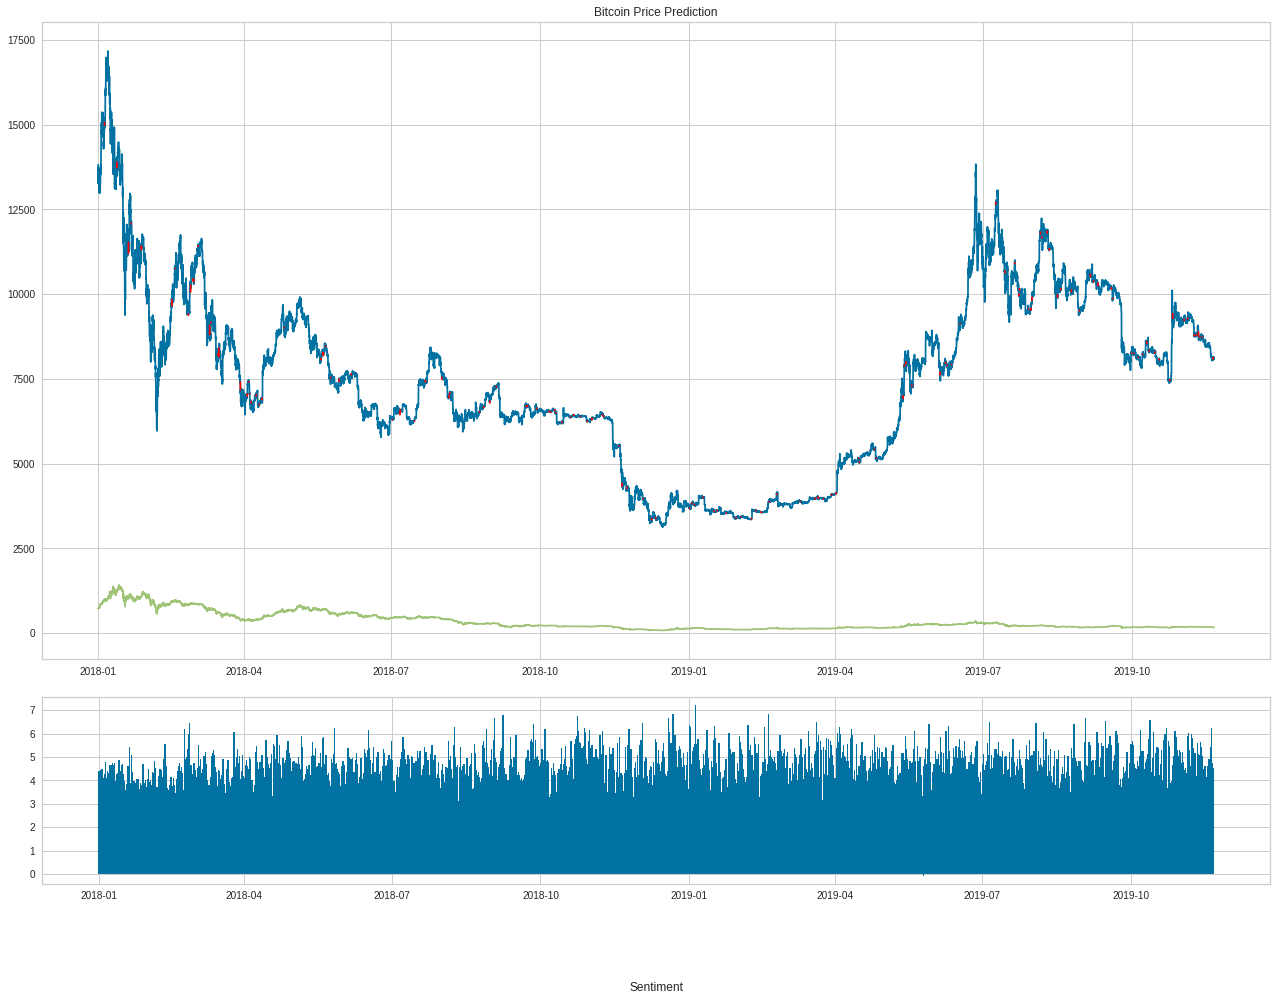

In [ ]:
import matplotlib.pyplot as plt

time_frame = df.index
price_org = df['open_BTCUSDT']
price_eth = df['close_ETHUSD']
sentiment = df['sentiment']
price_ev = unseen_with_nan['Predicted Price']

top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(time_frame, price_org)
top_plt.plot(time_frame, price_eth)
top_plt.plot(time_frame, price_ev, color='red')
plt.title('Bitcoin Price Prediction')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(time_frame, sentiment)
plt.title('\nSentiment', y=-0.60)
plt.gcf().set_size_inches(22,20)
plt.savefig('Bitcoin1.png')

## Training on 3 columns only

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/pratikpv/predicting_bitcoin_market/master/crypto_data_news_reddit_final.csv'
df = pd.read_csv(url, index_col=0, parse_dates=[0])
df.head()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23,728.77,625.293831,0.04257,...,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36,724.27,710.891607,0.04257,...,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55,722.11,849.257651,0.04257,...,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81,733.19,556.397003,0.04257,...,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39,738.59,1247.722800,0.04257,...,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757


In [ ]:
# selecting the 3 most relevant columns
df = df[['open_BTCUSDT', 'high_BTCUSDT', 'close_ETHUSD', 'close_LTCUSD']]


In [ ]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)
data_unseen.to_csv('unseen_data.csv')

print(f'Data for Modeling: %s' %str(data.shape))
print(f'Unseen Data For Predictions: %s' %str(data_unseen.shape))

# ~ 4.5 min runtime
target_col = 'open_BTCUSDT'
# session_id for reproducability
setup(data, target = target_col, train_size = 0.80, session_id = 1)
setup_df = pull()
# ranking based on R-squared
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,33.7415,3.724476e+03,60.8691,0.9994,0.0073,0.0043,0.264
br,Bayesian Ridge,33.7417,3.724474e+03,60.8691,0.9994,0.0073,0.0043,0.013
ridge,Ridge Regression,33.7415,3.724477e+03,60.8691,0.9994,0.0073,0.0043,0.010
en,Elastic Net,33.7423,3.724477e+03,60.8691,0.9994,0.0073,0.0043,0.018
huber,Huber Regressor,30.7423,4.110562e+03,63.9397,0.9994,0.0075,0.0039,0.067
omp,Orthogonal Matching Pursuit,34.5325,3.824239e+03,61.6848,0.9994,0.0074,0.0044,0.011
lar,Least Angle Regression,33.7415,3.724476e+03,60.8691,0.9994,0.0073,0.0043,0.011
knn,K Neighbors Regressor,32.6900,3.910465e+03,62.4063,0.9994,0.0073,0.0041,0.018
lasso,Lasso Regression,33.7428,3.724478e+03,60.8691,0.9994,0.0073,0.0043,0.012
rf,Random Forest Regressor,32.4579,3.877078e+03,62.0822,0.9994,0.0073,0.0040,2.213


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.5430,3767.5718,61.3806,0.9994,0.0069,0.0041
1,35.6591,3756.3132,61.2888,0.9995,0.0073,0.0045
2,33.8925,3351.2405,57.8899,0.9995,0.0068,0.0043
3,33.9394,4172.8862,64.5979,0.9993,0.0074,0.0043
4,32.1734,2967.3064,54.4730,0.9996,0.0065,0.0041
5,33.9212,3281.1016,57.2809,0.9995,0.0082,0.0045
6,34.4683,4462.0405,66.7985,0.9993,0.0083,0.0044
7,32.1249,3087.0413,55.5611,0.9996,0.0071,0.0041
8,35.3581,4651.9023,68.2049,0.9993,0.0077,0.0044


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
final_lr = finalize_model(lr)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=False, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Decla

In [ ]:
save_model(final_lr, 'bitcoin_lr')

seen_predictions = predict_model(lr)
labels = seen_predictions.pop('Label')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
seen_predictions.insert(1, 'Predicted Price', labels)
# preview
seen_predictions.head(n=10)
#seen_predictions.set_index(seen_id)

# this previously saved version consists of 50% of the entire data set -> upload dataset!!!
unseen_data = pd.read_csv('unseen_data.csv', index_col = 0, parse_dates=[0])
#unseen_data = pd.read_csv('last100unseen.csv', index_col = 0, parse_dates=[0])
unseen_predictions = predict_model(final_lr, data=unseen_data)


# popping the Label column with the predicted values 
labels = unseen_predictions.pop('Label')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
unseen_predictions.insert(1, 'Predicted Price', labels)
# preview
unseen_predictions.head(n=10)

full_dt = df.index
incomp_dt = unseen_predictions.index

d = pd.DataFrame(columns=['A'], index=range(len(full_dt)))

d['timestamp'] = full_dt
d = d.set_index(full_dt)
llll = d.pop('timestamp')
# inserting the popped column on the first index next to the open_BTCUSDT price we tried to predict
d.insert(0, 'timestamP', llll)

unseen_predictions.insert(0, 'timestamP', incomp_dt)

unseen_with_nan = d.merge(unseen_predictions,how='outer', left_on='timestamP', right_on='timestamP')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), model_name=bitcoin_lr, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='open_BTCUSDT',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_str...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrou

Transformation Pipeline and Model Successfully Saved


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,33.3428,3513.431641,59.2742,0.9995,0.0075,0.0043


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,31.5621,2938.11,54.2043,0.9996,0.0065,0.004


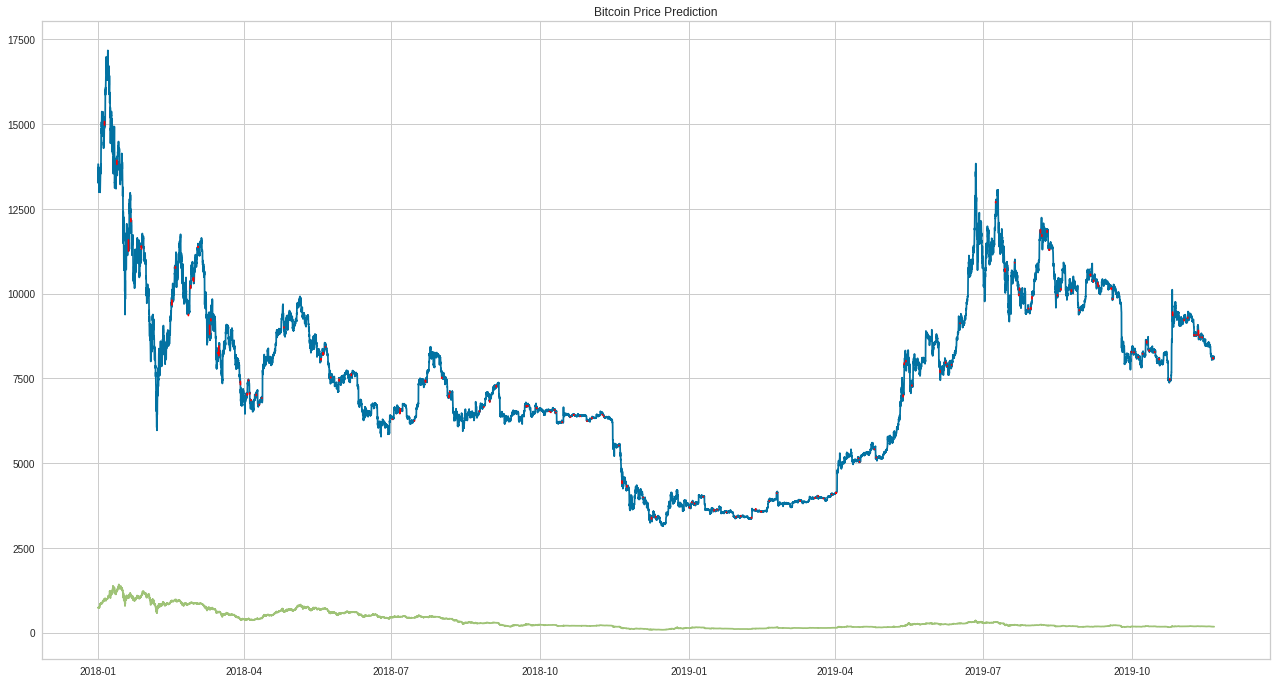

In [ ]:
import matplotlib.pyplot as plt

time_frame = df.index
price_org = df['open_BTCUSDT']
price_eth = df['close_ETHUSD']
price_ev = unseen_with_nan['Predicted Price']

top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(time_frame, price_org)
top_plt.plot(time_frame, price_eth)
top_plt.plot(time_frame, price_ev, color='red')
plt.title('Bitcoin Price Prediction')
plt.gcf().set_size_inches(22,20)
plt.savefig('Bitcoin1.png')

## LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#np.set_printoptions(threshold=np.inf)

**Fetching the data and assigning it to a variable**

In [ ]:
org_df = pd.read_csv('crypto_data_news_reddit_final.csv',index_col=0)

**Feature Engineering**

In [ ]:
org_df['flair'] = org_df['gnews_flair'] + org_df['reddit_flair']
org_df['tb_polarity'] = org_df['gnews_tb_polarity'] + org_df['reddit_tb_polarity']
org_df['tb_subjectivity'] = org_df['gnews_tb_subjectivity'] + org_df['reddit_tb_subjectivity']
org_df['sid_pos'] = org_df['gnews_sid_pos'] + org_df['reddit_sid_pos']
org_df['sid_neg'] = org_df['gnews_sid_neg'] + org_df['reddit_sid_neg']
org_df = org_df[['open_BTCUSDT','high_BTCUSDT','low_BTCUSDT', 'close_BTCUSDT',
                 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
                 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']]


**Data Scaling**

In [ ]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset) # to np.array
print(f'dataset.shape: %i rows and %i columns' %(dataset.shape[0], dataset.shape[1]))
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

In [ ]:
dataset

**Configuration** of variables

In [ ]:
expr_name = 'expr_4'
look_back = 24*120 # 60 days, as each entry is for 1 hour
lstm_layers = 64
epochs = 5
batch_size = 128

**Preparing Test and Training Data**

In [ ]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close_BTCUSDT')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length', len(train), sep=': ')
print('Testing dataset length', len(test), sep=': ')
print('look_back', look_back, sep=' = ')

**LSTM Model**

In [ ]:
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back, num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size, shuffle=False)

**Visualizing the Training with Matplotlib**

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

**Prediction: Evaluation of the LSTM-model's performance**

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

**Plotting the results**

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# construct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)
print(time_df2)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
#plt.savefig(expr_name + '.png',bbox_inches = "tight")

**Report**

In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()